### 모바일 넷 전이 학습 with NN

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

In [28]:
print(tf.__version__)

### GPU negative 문제 해결
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### GPU 사용 가능 여부 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("사용 가능한 GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("GPU가 인식되지 않았습니다.")

2.17.0
사용 가능한 GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "DejaVu Sans")
plt.rcParams["axes.unicode_minus"] = False

In [30]:
from sklearn.model_selection import train_test_split

### 경로 불러오기
- train, test 를 따로 불러오지 않고 하나의 폴더째로 불러와서 나눈후 테스트 데이터에 대해서만 증강

In [31]:
def load_images_and_labels(files, label, size):
    images = [image.load_img(p, target_size=(size, size)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels

In [32]:
man_file= glob('../data/imgs/data_mw/man/*jpg')
wom_file= glob('../data/imgs/data_mw/woman/*jpg')

man_file_224_x, man_file_224_y = load_images_and_labels(man_file, 0, 224)
wom_file_224_x, wom_file_224_y = load_images_and_labels(wom_file, 1, 224)

['../data/imgs/data_mw/man/ma_194.jpg', '../data/imgs/data_mw/man/ma_44.jpg', '../data/imgs/data_mw/man/ma_117.jpg', '../data/imgs/data_mw/man/ma_77.jpg', '../data/imgs/data_mw/man/ma_165.jpg', '../data/imgs/data_mw/man/ma_163.jpg', '../data/imgs/data_mw/man/ma_119.jpg', '../data/imgs/data_mw/man/ma_26.jpg', '../data/imgs/data_mw/man/ma_50.jpg', '../data/imgs/data_mw/man/ma_144.jpg', '../data/imgs/data_mw/man/ma_99.jpg', '../data/imgs/data_mw/man/ma_19.jpg', '../data/imgs/data_mw/man/ma_9.jpg', '../data/imgs/data_mw/man/ma_147.jpg', '../data/imgs/data_mw/man/ma_171.jpg', '../data/imgs/data_mw/man/ma_88.jpg', '../data/imgs/data_mw/man/ma_94.jpg', '../data/imgs/data_mw/man/ma_100.jpg', '../data/imgs/data_mw/man/ma_8.jpg', '../data/imgs/data_mw/man/ma_71.jpg', '../data/imgs/data_mw/man/ma_55.jpg', '../data/imgs/data_mw/man/ma_49.jpg', '../data/imgs/data_mw/man/ma_39.jpg', '../data/imgs/data_mw/man/ma_157.jpg', '../data/imgs/data_mw/man/ma_60.jpg', '../data/imgs/data_mw/man/ma_185.jpg', '.

In [33]:
from tensorflow.keras.utils import to_categorical

In [34]:
images_224 = man_file_224_x + wom_file_224_x
labels = man_file_224_y + wom_file_224_y
labels = to_categorical(labels)
vector_224 = np.asarray([image.img_to_array(img) for img in images_224])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(vector_224, labels, random_state=42, test_size=0.2)

In [36]:
### train data 증강하기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False)

train_augmented_images = train_datagen.flow(x_train, y_train,
                                            shuffle=True,
                                            batch_size=64)

### test 안 증강
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_augmented_images = test_datagen.flow(x_test, y_test,
                                            shuffle=True,
                                            batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99766487..0.9336971].


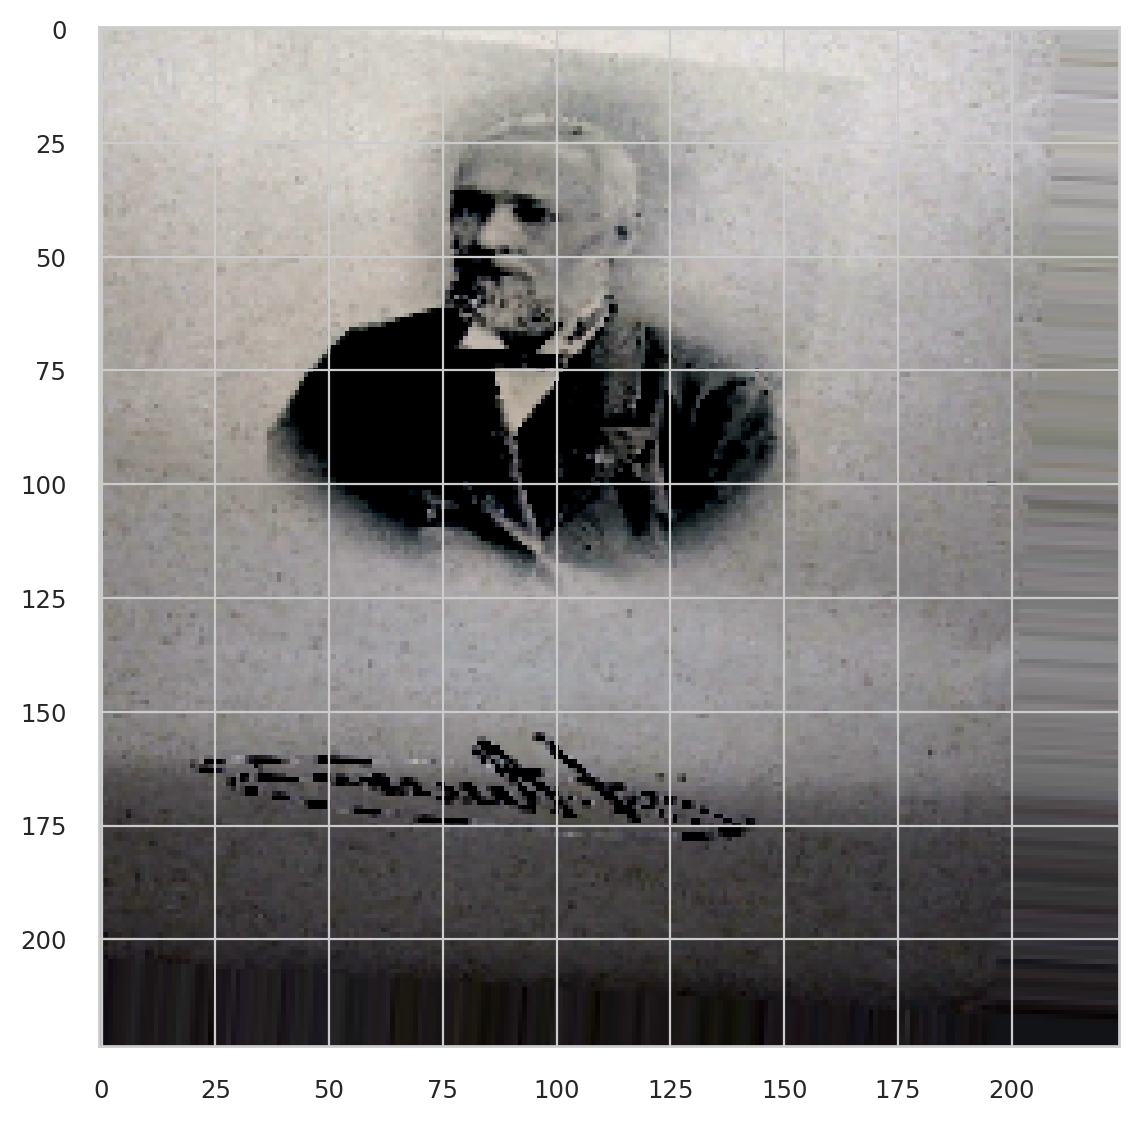

In [37]:
# # 증강 확인
plt.imshow(train_augmented_images[0][0][15])

In [38]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Concatenate, Conv1D, Reshape, GlobalAveragePooling1D, MaxPool1D, BatchNormalization

In [39]:
def model_maker():
    
    # top 층을 제외한 사전학습 모형 호출
    base_model = MobileNet(include_top=False,
                           weights='imagenet',
                           input_shape=(224, 224, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False

    # Input 클래스를 이용해서 입력 데이터의 형태를 지정
    input_ = Input(shape=(224, 224, 3))
    x = base_model(input_)
    x = GlobalAveragePooling2D()(x)

    for n_ in [512, 256, 128, 64]:

        x = Dense(n_)(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)

    predictions  = Dense(2, activation='softmax')(x)
    return Model(inputs=input_, outputs=predictions)

In [40]:

import inspect
import sys
import io
import os

name_ = '전이 학습'
codes_ = inspect.getsource(model_maker)

model = model_maker()
model.summary()

summary_str = io.StringIO()
model.summary(print_fn=lambda x: summary_str.write(x + '\n'))

folder = 'result/'
files = os.listdir(folder)

last_number = int(len(files) / 3)
with open(folder + f'{name_}_{last_number}.txt', 'w') as f:
    f.write(codes_ + '\n\n')
    f.write(summary_str.getvalue() + '\n\n')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,930,114 (14.99 MB)

 Trainable params: 699,330 (2.67 MB)

 Non-trainable params: 3,230,784 (12.32 MB)

### 트레인 데이터 확인

[1. 0.]


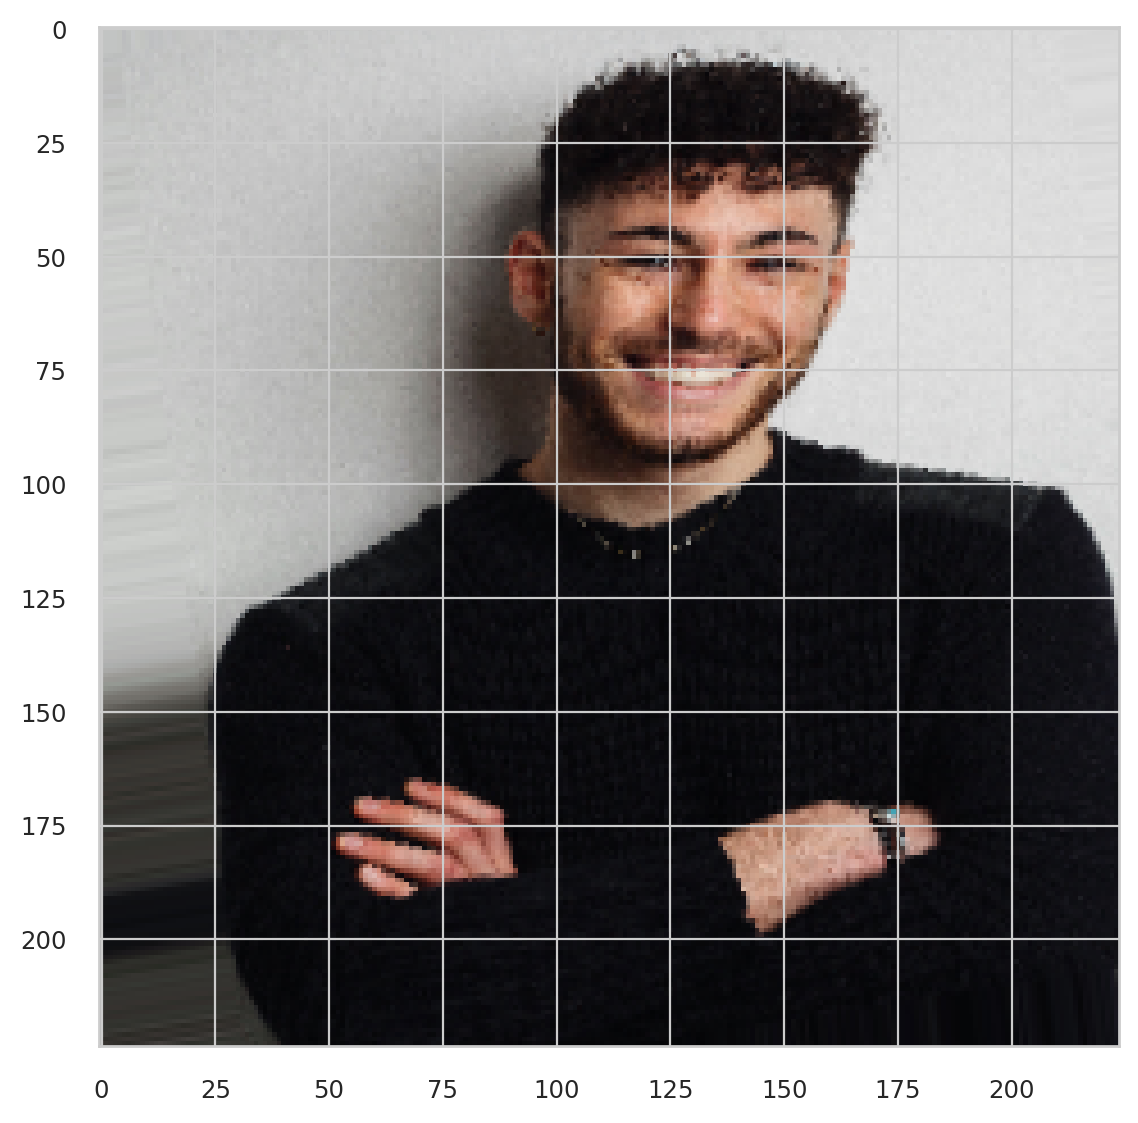

In [41]:
for i in train_augmented_images:
    plt.imshow((i[0][0] + 1)/2)
    print(i[1][0])
    break

### 테스트 데이터 확인

[0. 1.]


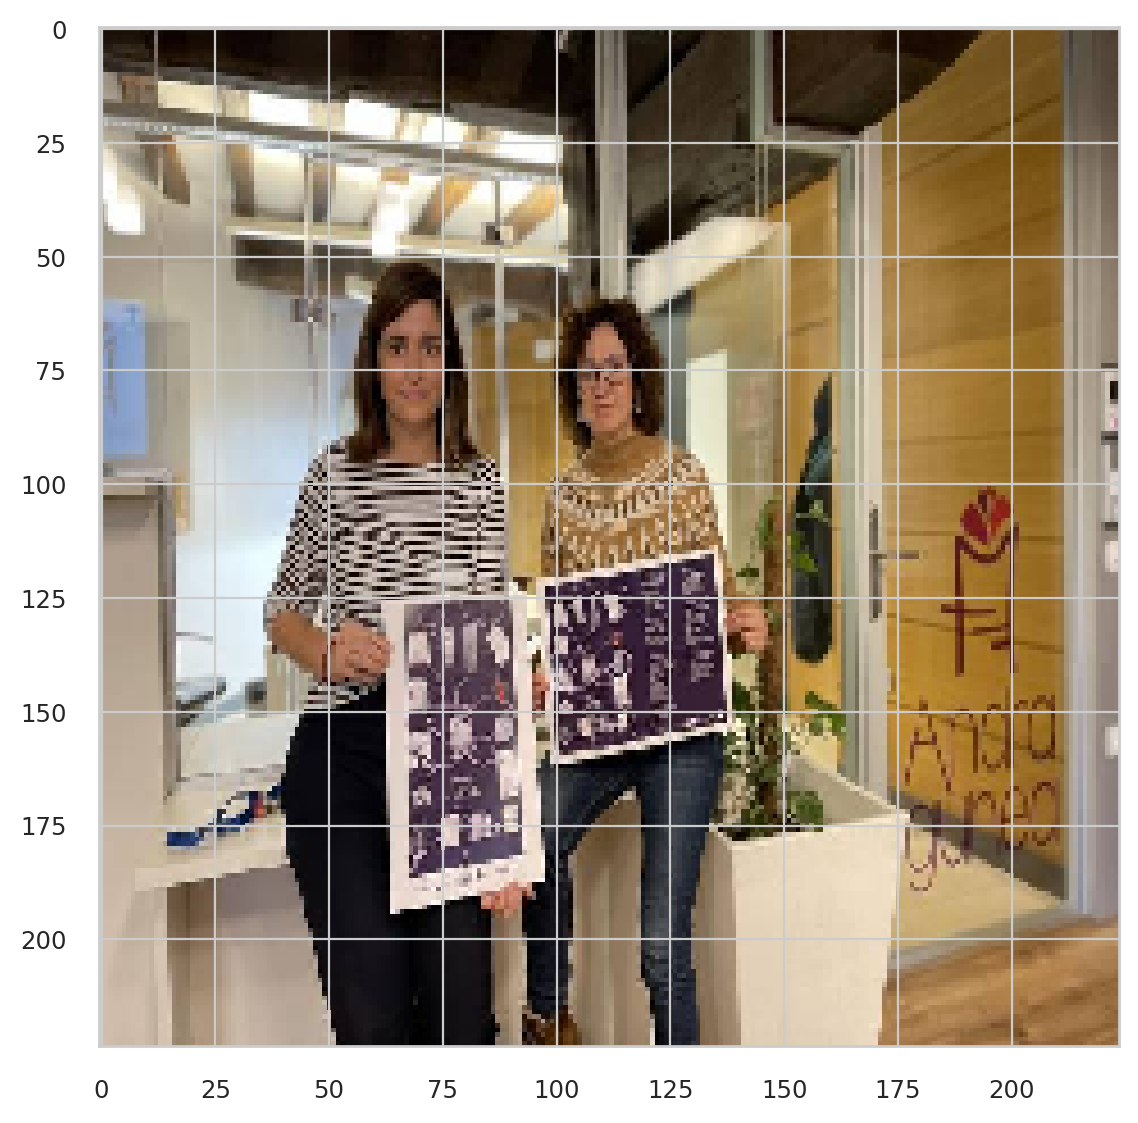

In [42]:
for i in test_augmented_images:
    plt.imshow((i[0][0] + 1)/2)
    print(i[1][0])
    break

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.00005),
              metrics=['acc'])

In [44]:
with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write(model.loss + '\n')
    f.write(f'Model_optimizer : {model.optimizer.__str__()}' + '\n')
    f.write(f'Model_Learning_rate : {model.optimizer.learning_rate.numpy():.5f}' + '\n\n')

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(patience=20)
checkpoint = ModelCheckpoint('2_2_transfer_final_model.keras',
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

In [46]:
history = model.fit(
                    train_augmented_images,
                    # x_train,y_train,
                    batch_size = 32,
                    epochs = 1200,
                    callbacks=[checkpoint, es],
                    validation_data = test_augmented_images)

Epoch 1/1200


/home/tommy/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - acc: 0.5370 - loss: 0.9289
Epoch 1: val_loss improved from inf to 0.86487, saving model to 2_2_transfer_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - acc: 0.5373 - loss: 0.9353 - val_acc: 0.5441 - val_loss: 0.8649
Epoch 2/1200
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.6050 - loss: 0.8992
Epoch 2: val_loss improved from 0.86487 to 0.69059, saving model to 2_2_transfer_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - acc: 0.5913 - loss: 0.8751 - val_acc: 0.6618 - val_loss: 0.6906
Epoch 3/1200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6599 - loss: 0.7276
Epoch 3: val_loss improved from 0.69059 to 0.58709, saving model to 2_2_transfer_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - acc: 0.6639 - loss: 0.7248 - val_acc: 0.6765 - val_loss: 0.5871
Epoch 4/1200
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.7086 - loss: 0.6514
Epoch 4: val_loss improved from 0.58709 to 0.52679, saving model to 2_2_transfer_final_m

In [47]:
with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write('epoch, loss, acc, val_loss, val_accu' + '\n')

for each in range(len(history.history['loss'])):
    loss= format(history.history['loss'][each], '.4f')
    acc = format(history.history['acc'][each], '.4f')
    val_loss = format(history.history['val_loss'][each], '.4f')
    val_accu = format(history.history['val_acc'][each], '.4f')
    print(loss,acc,val_loss,val_accu)
    with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
        f.write(f'{loss},{acc},{val_loss},{val_accu}' + '\n')

0.9676 0.5390 0.8649 0.5441
0.8436 0.5762 0.6906 0.6618
0.7106 0.6840 0.5871 0.6765
0.6679 0.6914 0.5268 0.7206
0.6529 0.7398 0.4831 0.7794
0.6080 0.7212 0.4518 0.8235
0.6001 0.7361 0.4295 0.8235
0.5711 0.7361 0.4218 0.8382
0.5161 0.7881 0.4156 0.8382
0.4552 0.7732 0.4085 0.8088
0.3777 0.8253 0.4084 0.8235
0.4691 0.8067 0.4018 0.8235
0.4163 0.8030 0.3978 0.8235
0.3813 0.8141 0.3932 0.8235
0.4524 0.8104 0.3873 0.8235
0.3663 0.8476 0.3738 0.8382
0.3833 0.8178 0.3683 0.8529
0.3697 0.8401 0.3676 0.8529
0.4101 0.8030 0.3656 0.8529
0.3533 0.8587 0.3606 0.8382
0.3316 0.8662 0.3607 0.8382
0.2911 0.8699 0.3593 0.8382
0.3241 0.8662 0.3559 0.8382
0.3992 0.8327 0.3608 0.8382
0.3381 0.8513 0.3650 0.8529
0.3327 0.8625 0.3633 0.8529
0.2320 0.9071 0.3589 0.8382
0.3212 0.8550 0.3540 0.8235
0.3020 0.8587 0.3537 0.8235
0.2530 0.8922 0.3533 0.8382
0.2480 0.8922 0.3579 0.8529
0.2706 0.8848 0.3571 0.8676
0.2397 0.8885 0.3523 0.8529
0.3294 0.8327 0.3501 0.8529
0.2802 0.8848 0.3491 0.8529
0.2786 0.8885 0.3489

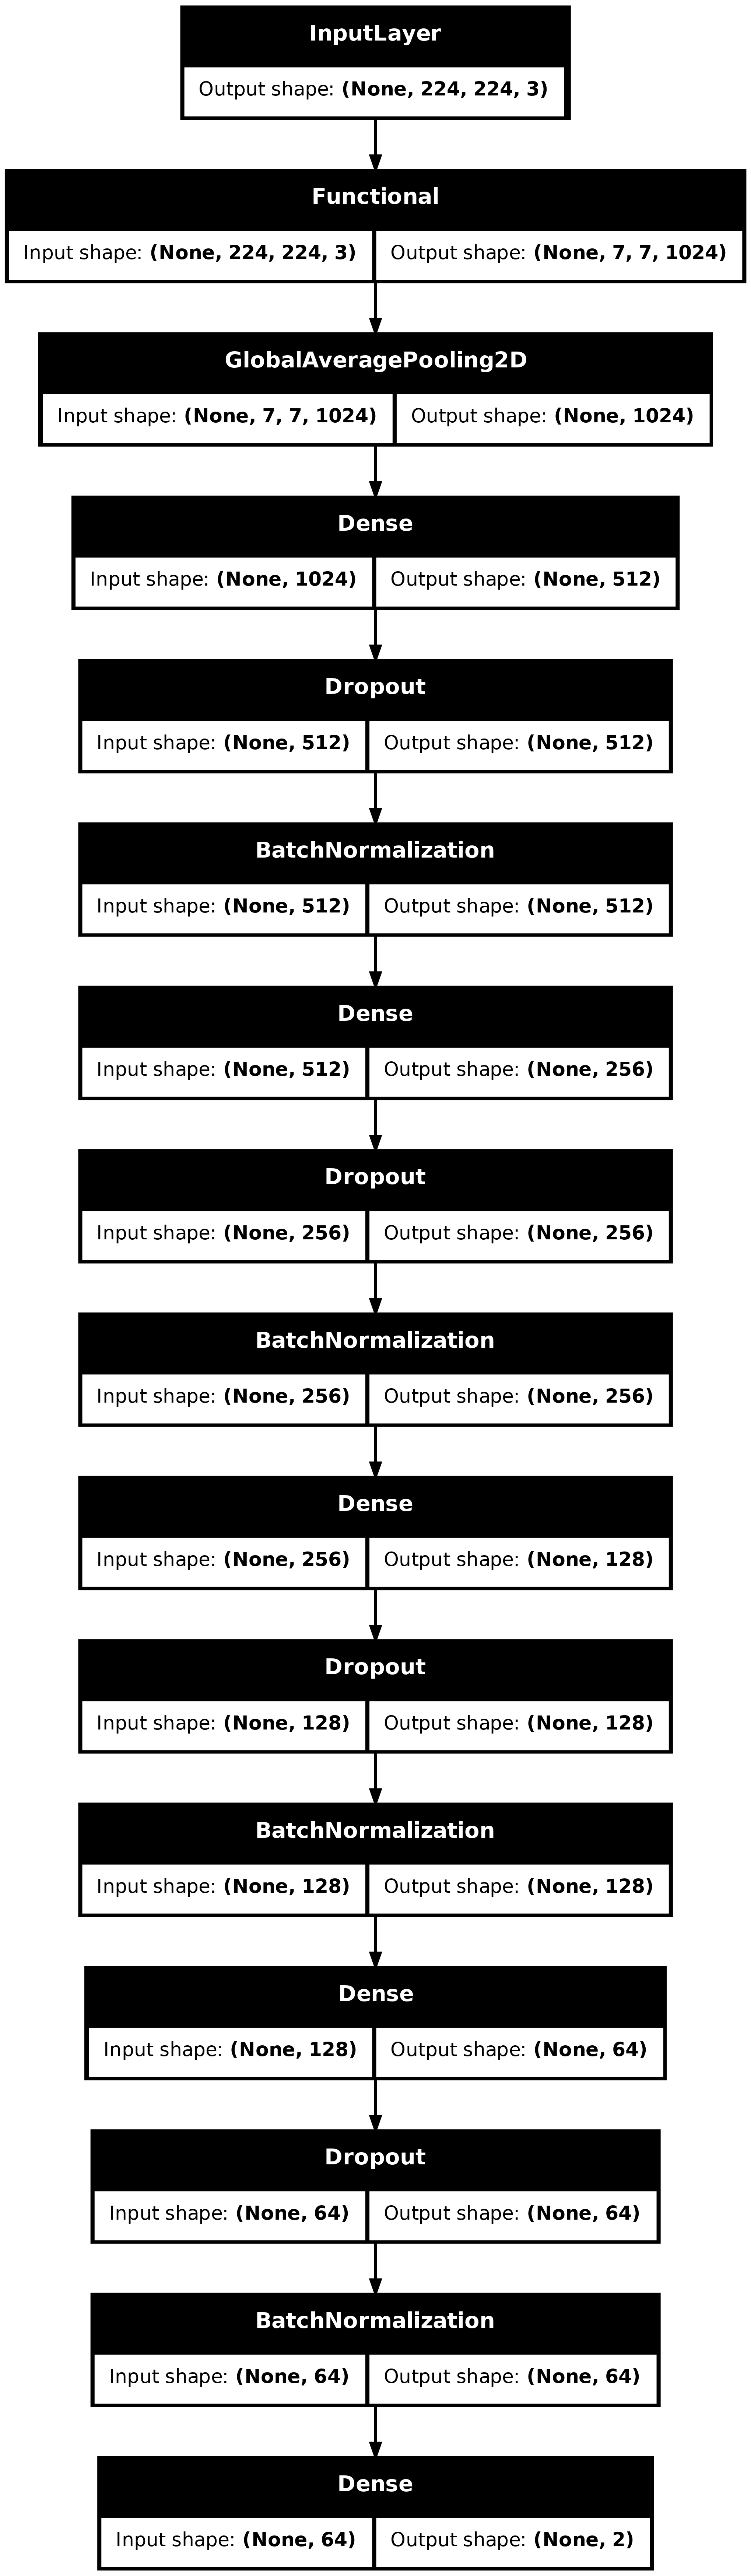

In [48]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

plot_model(model, to_file= folder + f'{name_}_{last_number}.png', show_shapes=True, show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=266,
    show_layer_activations=False,)

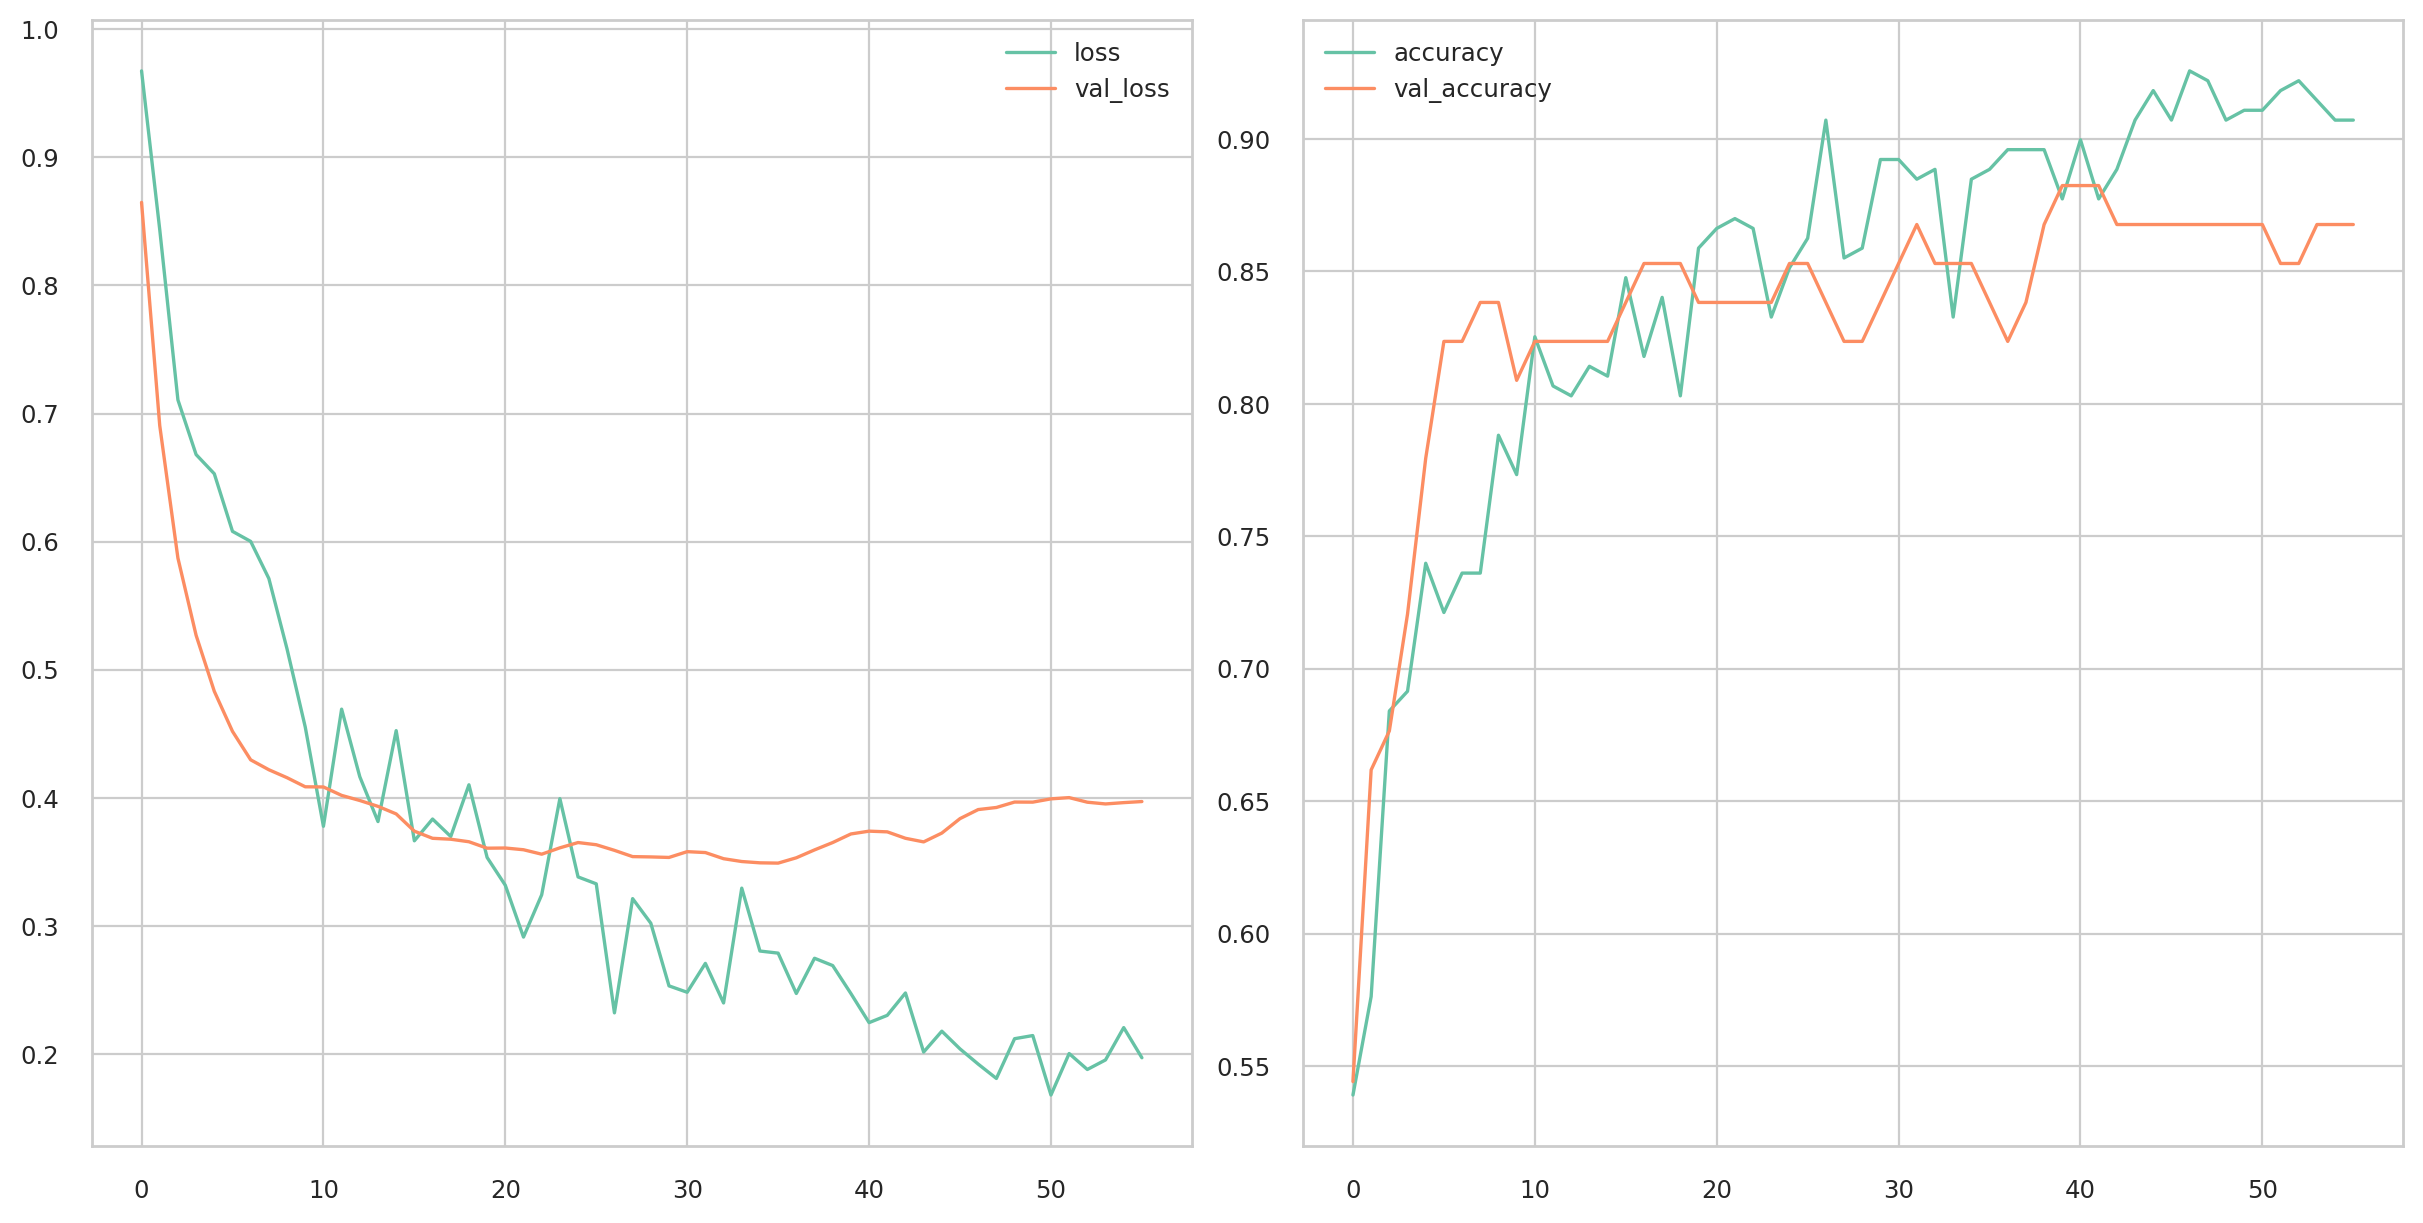

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(history.history['loss'],
             label='loss',
             ax=ax[0])

sns.lineplot(history.history['val_loss'],
             label='val_loss',
             ax=ax[0])

sns.lineplot(history.history['acc'],
             label='accuracy',
             ax=ax[1])

sns.lineplot(history.history['val_acc'],
             label='val_accuracy',
             ax=ax[1])

fig.savefig(folder + f"{name_}_{last_number}_graph.png")

In [50]:
model.load_weights('2_2_transfer_final_model.keras')

In [51]:
from sklearn.metrics import f1_score

In [52]:
pred = [i.argmax() for i in model.predict(x_test,verbose=0)]
y_real = [i.argmax() for i in y_test]

f1 = f1_score(pred,y_real)
final_result_ = f'정확도 : {model.evaluate(test_augmented_images, verbose=0)[1]}, f1_socre: {f1}'

with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write('최종 스코어' + '\n')
    f.write('\n\n' + final_result_ + '\n')

```py


```

